In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv(
    "../data/wheat_price_monthly.csv",
    parse_dates=["date"]
)

df = df.sort_values("date").set_index("date")

df.head()

,price_usd_ton
date,
2000-01-01,114.2
2000-02-01,113.8
2000-03-01,115.6
2000-04-01,118.9
2000-05-01,121.4


In [3]:
train = df.loc[: "2018-12-01"]
test  = df.loc["2019-01-01":]

y_train = train["price_usd_ton"]
y_test  = test["price_usd_ton"]

len(train), len(test), y_train.index.min(), y_train.index.max(), y_test.index.min()


(228,
 60,
 Timestamp('2000-01-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'))

In [4]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [5]:
naive_forecast = np.repeat(y_train.iloc[-1], len(y_test))

rmse_naive = rmse(y_test, naive_forecast)
mae_naive  = mean_absolute_error(y_test, naive_forecast)

rmse_naive, mae_naive

(211.4594653828483, 172.505)

In [6]:
seasonal_forecast = []
for date in y_test.index:
    last_year = date - pd.DateOffset(years=1)
    if last_year in df.index:
        seasonal_forecast.append(df.loc[last_year, "price_usd_ton"])
    else:
        seasonal_forecast.append(np.nan)

seasonal_forecast = pd.Series(seasonal_forecast, index=y_test.index)

# drop any missing (should be none if your series is complete)
mask = ~seasonal_forecast.isna()

rmse_seasonal = rmse(y_test[mask], seasonal_forecast[mask])
mae_seasonal  = mean_absolute_error(y_test[mask], seasonal_forecast[mask])

rmse_seasonal, mae_seasonal

(83.52671528718622, 64.23833333333333)

In [7]:
def make_lags(series, lags):
    X = pd.concat({f"lag_{l}": series.shift(l) for l in lags}, axis=1)
    return X

lags = [1, 3, 6, 12]

X_all = make_lags(df["price_usd_ton"], lags)
data = pd.concat([X_all, df["price_usd_ton"]], axis=1).dropna()

train_ml = data.loc[: "2018-12-01"]
test_ml  = data.loc["2019-01-01":]

X_train = train_ml.drop(columns="price_usd_ton")
y_train_ml = train_ml["price_usd_ton"]

X_test = test_ml.drop(columns="price_usd_ton")
y_test_ml = test_ml["price_usd_ton"]

model = Ridge(alpha=1.0)
model.fit(X_train, y_train_ml)

y_pred = model.predict(X_test)

rmse_ridge = rmse(y_test_ml, y_pred)
mae_ridge  = mean_absolute_error(y_test_ml, y_pred)

rmse_ridge, mae_ridge

(11.175266033086013, 8.529035663944608)

In [8]:
results = pd.DataFrame({
    "model": ["Naive", "Seasonal Naive", "Ridge (lags)"],
    "RMSE": [rmse_naive, rmse_seasonal, rmse_ridge],
    "MAE":  [mae_naive, mae_seasonal, mae_ridge]
}).sort_values("RMSE")

results

,model,RMSE,MAE
2,Ridge (lags),11.175266,8.529036
1,Seasonal Naive,83.526715,64.238333
0,Naive,211.459465,172.505000


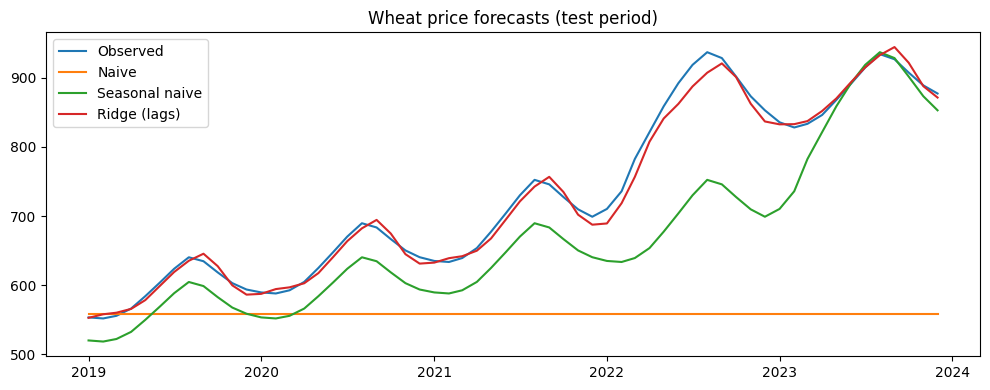

In [9]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Observed")
plt.plot(y_test.index, naive_forecast, label="Naive")
plt.plot(y_test.index, seasonal_forecast, label="Seasonal naive")
plt.plot(y_test_ml.index, y_pred, label="Ridge (lags)")
plt.legend()
plt.title("Wheat price forecasts (test period)")
plt.tight_layout()
plt.show()

In [10]:
plt.figure(figsize=(10,4))
plt.plot(y_test_ml.index, y_test_ml, label="Observed")
plt.plot(y_test_ml.index, y_pred, label="Ridge (lags)")
plt.legend()
plt.title("Ridge forecast vs observed")
plt.tight_layout()
plt.savefig("../outputs/figures/forecast_vs_observed.png")
plt.close()